# <center>拍拍贷风险评估解决方案</center>
<center>王雪纯 15307100119</center>     
## 一、解决方案概述
### 1.1	 问题识别
&emsp;&emsp;拍拍贷公司从超过200个数据维度，通过借款人的特征、网络行为、学历以及第三方数据等全面信息，来评估用户的信用状态，并通过大数据来预测借款人的信贷违约风险。  
&emsp;&emsp;因此，考虑将问题转化成了一个二分类问题，评估指标为Accuracy、AUC、Confusion Matrix。
### 1.2	 解决方案
&emsp;&emsp;首先是**数据导入与数据清洗**，除了本身的数据，还引入了股票市场、IPO等维度的外部信息，之后对缺失值进行了多种处理，并对一些变量进行了删除和转化；进一步进行了**特征工程**，这里我们对分类变量、时间变量、地区变量等进行了特征构建和提取；在具体建模之前，我们对**数据不平衡**进行了处理，主要使用了SMOTE的方法；最后便是**模型的建立**，使用了XGBoost、可解释性较强的逻辑回归模型、以及两种Stacking的模型融合，令人出乎意料的是，朴素的逻辑回归领跑全局，提升百分比高达60%，收益增加了360余亿元。

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

## 二、数据导入与数据清洗
### 2.1 数据导入
&emsp;&emsp;分别导入`PPDtrain`、`PPDtest`，`provinc_city_lookup`，`stock_v4`，`ipo_data_v2`数据集，并将其按时间、地点对应融合，使得原数据集又增加了股票市场、IPO等维度的特征值，并按照`provinc_city_lookup`对原数据集中的城市进行分级。  
&emsp;&emsp;可以看见融合后数据维度从226增加到了278。

In [3]:
# load files
f = open('PPDtrain.csv', 'rb')
train = pd.read_csv(f, index_col ='Idx', encoding='gb18030')
f1 = open('provinc_city_lookup.csv', 'rb')
province = pd.read_csv(f1, encoding='gb18030')
f2 = open('stock_v4.csv', 'rb')
stock = pd.read_csv(f2, encoding='gb18030')
f3 = open('ipo_data_v2.csv', 'rb')
ipo = pd.read_csv(f3, encoding='gb18030')
f4 = open('PPDtest.csv', 'rb')
test = pd.read_csv(f4, index_col = 'Idx', encoding='gb18030')
print('train shape: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape: %d * %d' %(test.shape[0], test.shape[1]))

train shape: 21000 * 226
test shape: 9000 * 226


In [4]:
# merge data and stock, ipo, location
prov = {}
for i in range(len(province)):
    if province.iloc[i][0] not in prov:
        prov[province.iloc[i][0]] = province.iloc[i][2]
provs = pd.DataFrame.from_dict(prov,orient='index')
train['UserInfo_2'].fillna('其他', inplace = True)
test['UserInfo_2'].fillna('其他', inplace = True)
train = pd.merge(train, provs, left_on = 'UserInfo_2', right_index = True, copy = False)
test = pd.merge(test, provs, left_on = 'UserInfo_2', right_index = True, copy = False)
train['ListingInfo'] = pd.to_datetime(train.ListingInfo)
stock['date'] = pd.to_datetime(stock.date)
test['ListingInfo'] = pd.to_datetime(test.ListingInfo)
ipo['date'] = pd.to_datetime(ipo.date)
train = pd.merge(train, stock, left_on = 'ListingInfo', right_on = 'date')
train = pd.merge(train, ipo, left_on = 'ListingInfo', right_on = 'date')
test = pd.merge(test, stock, left_on = 'ListingInfo', right_on = 'date')
test = pd.merge(test, ipo, left_on = 'ListingInfo', right_on = 'date')
del train['date_x']
del train['date_y']
del test['date_x']
del test['date_y']
print('train shape after merging: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape after merging: %d * %d' %(test.shape[0], test.shape[1]))

train shape after merging: 21000 * 278
test shape after merging: 9000 * 278


In [5]:
train_target = train['target']
test_target = test['target']

### 2.2 数据清洗
#### 2.2.1 删除缺失值过多特征值
&emsp;&emsp;由于缺失值过多会影响到模型的效果，我选取了缺失值超过观测数$\frac 56$的特征值进行了剔除，具体显示如下，共计剔除了8个变量。

In [6]:
for name in train.columns:
        if train[name].count() < len(train)*5/6:
            print('drop:', name)
            train.drop(name, axis = 1, inplace = True)
            test.drop(name, axis = 1, inplace = True)
print('\ntrain shape: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape: %d * %d' %(test.shape[0], test.shape[1]))

drop: WeblogInfo_1
drop: WeblogInfo_3
drop: UserInfo_10
drop: UserInfo_11
drop: UserInfo_12
drop: WeblogInfo_20
drop: Unnamed: 16
drop: Unnamed: 17

train shape: 21000 * 270
test shape: 9000 * 270


#### 2.2.2 删除城市（结合外部文件已做过处理）
&emsp;&emsp;这边主要是将城市按照助教姐姐提供的csv文件进行分级，处理完后将文件中有关地理的特征值进行剔除，共剔除了7条。

In [7]:
cities = ['UserInfo_2', 'UserInfo_4', 'UserInfo_6', 'UserInfo_7', \
          'UserInfo_18', 'UserInfo_19', 'UserInfo_23']
for name in cities:
    train.drop(name, axis = 1, inplace = True)
    test.drop(name, axis = 1, inplace = True)
print('\ntrain shape: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape: %d * %d' %(test.shape[0], test.shape[1]))


train shape: 21000 * 263
test shape: 9000 * 263


#### 2.2.3 删除影响很小的变量（方差小）
&emsp;&emsp;注意到有很多特征值的变化很小，比如`WeblogInfo_10`这一变量只有0这一数值，对于违约风险的预测没有任何帮助。我选取了方差小于0.1的变量进行剔除，这样的变量还真不少，达到了53个。

In [8]:
for name in train.columns:
    if train[name].dtypes == 'int64' or train[name].dtypes == 'float64':
        var = np.var(train[name])
        if var < 0.1:
            print("%s's variance: %f" %(name, var))
            train.drop(name, axis = 1, inplace = True)
            test.drop(name, axis = 1, inplace = True)
print('\ntrain shape: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape: %d * %d' %(test.shape[0], test.shape[1]))

WeblogInfo_10's variance: 0.000000
WeblogInfo_11's variance: 0.042652
WeblogInfo_13's variance: 0.001428
UserInfo_20's variance: 0.065959
Education_Info1's variance: 0.059987
Education_Info5's variance: 0.030530
WeblogInfo_23's variance: 0.007780
WeblogInfo_25's variance: 0.031667
WeblogInfo_26's variance: 0.013844
WeblogInfo_28's variance: 0.015152
WeblogInfo_29's variance: 0.030969
WeblogInfo_31's variance: 0.007046
WeblogInfo_32's variance: 0.006021
WeblogInfo_34's variance: 0.023384
WeblogInfo_35's variance: 0.010788
WeblogInfo_37's variance: 0.012611
WeblogInfo_38's variance: 0.022478
WeblogInfo_40's variance: 0.005276
WeblogInfo_41's variance: 0.000288
WeblogInfo_43's variance: 0.001534
WeblogInfo_44's variance: 0.000288
WeblogInfo_45's variance: 0.026321
WeblogInfo_46's variance: 0.000720
WeblogInfo_47's variance: 0.001726
WeblogInfo_48's variance: 0.046311
WeblogInfo_49's variance: 0.000000
WeblogInfo_50's variance: 0.017196
WeblogInfo_51's variance: 0.013485
WeblogInfo_52's va

#### 2.2.4 删除有缺失值的观测
&emsp;&emsp;最后，为了模型构建的方便，对训练数据集中有缺失值的观测进行了剔除，剔除后还余17880条观测。

In [9]:
train.dropna(inplace = True)
train_target = train_target.loc[train.index]
print('train shape: %d * %d' %(train.shape[0], train.shape[1]))

train shape: 17880 * 210


## 三、特征工程
### 3.1 处理分类变量
&emsp;&emsp;由于模型无法处理字符型的分类变量，我对这些变量进行了处理。可以看见字符型的分类变量共有12个，其中ListingInfo为时间序列变量，此处不予处理，在之后的时间变量处理中进行讨论。

In [10]:
for name in train.columns:
    if train[name].dtypes != 'int64' and train[name].dtypes != 'float64':
        print(name)

UserInfo_8
UserInfo_21
UserInfo_22
Education_Info2
Education_Info3
Education_Info4
Education_Info6
Education_Info7
Education_Info8
WeblogInfo_19
WeblogInfo_21
ListingInfo


&emsp;&emsp;接下来对11个变量的各个取值以及数量进行了可视化。  
&emsp;&emsp;可以看见，11个分类变量中，部分变量分布分布非常不均匀，考虑对数量太少的类别进行合并，形成新的0-1变量，具体如下：
- `UserInfo_21`：D为一类，其余为一类
- `UserInfo_22`：D为一类，其余为一类
- `Education_Info2`：E为一类，其余为一类
- `Education_Info3`：E为一类，其余为一类
- `Education_Info4`：E为一类，其余为一类
- `Education_Info6`：E为一类，其余为一类
- `Education_Info8`：E为一类，其余为一类
- `WeblogInfo_19`：I为一类，其余为一类
- `WeblogInfo_21`：D为一类，其余为一类

&emsp;&emsp;其余变量不变，按照原取值进行独热编码。

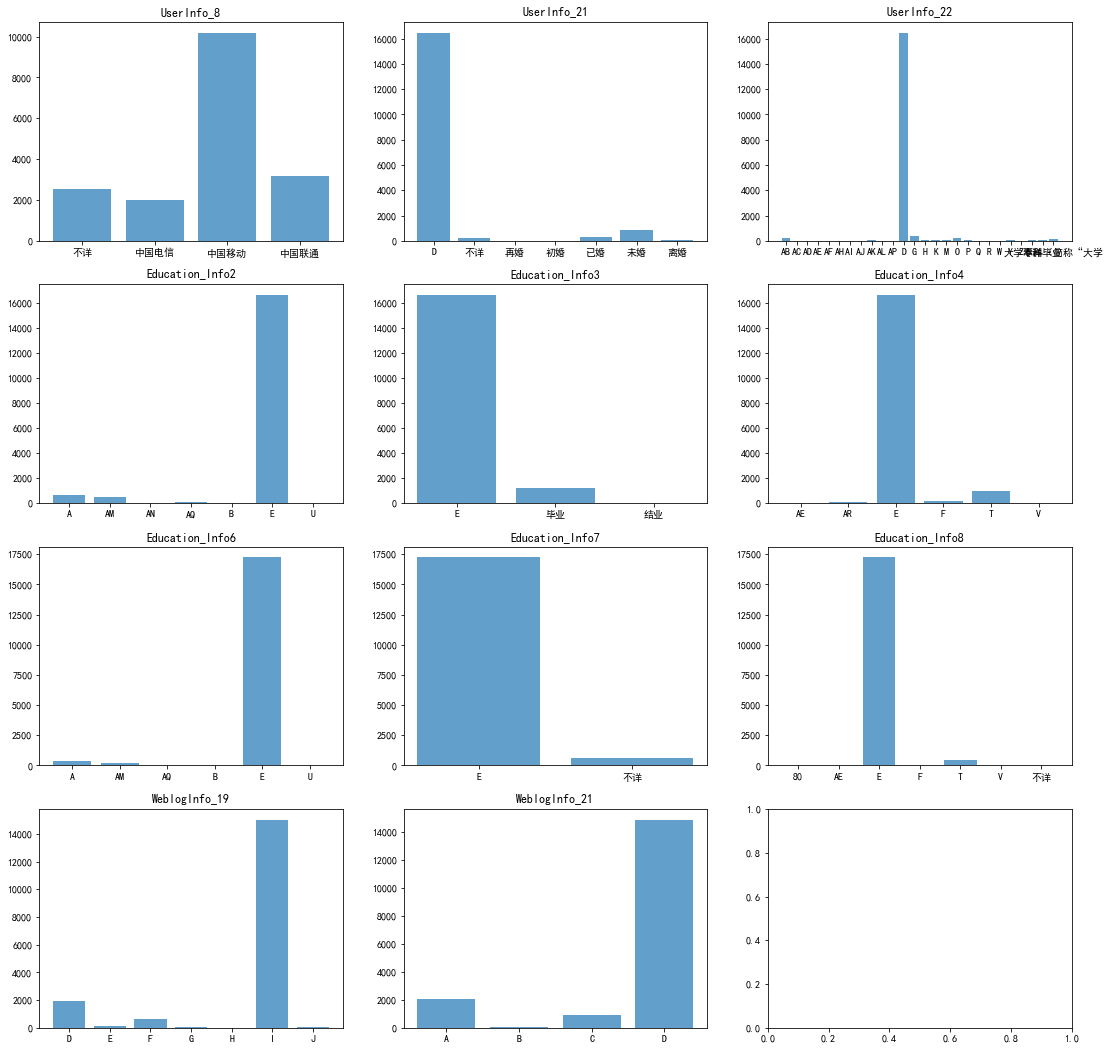

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
fig, axes = plt.subplots(ncols = 3, nrows = 4)
fig.set_size_inches(18.5, 18.5)
axes[0,0].bar(Counter(train['UserInfo_8']).keys(),Counter(train['UserInfo_8']).values(), alpha = .7)
axes[0,0].set_title('UserInfo_8')
axes[0,1].bar(Counter(train['UserInfo_21']).keys(),Counter(train['UserInfo_21']).values(), alpha = .7, )
axes[0,1].set_title('UserInfo_21')
axes[0,2].bar(Counter(train['UserInfo_22']).keys(),Counter(train['UserInfo_22']).values(), alpha = .7, )
axes[0,2].set_title('UserInfo_22')
axes[1,0].bar(Counter(train['Education_Info2']).keys(),Counter(train['Education_Info2']).values(), alpha = .7, )
axes[1,0].set_title('Education_Info2')
axes[1,1].bar(Counter(train['Education_Info3']).keys(),Counter(train['Education_Info3']).values(), alpha = .7, )
axes[1,1].set_title('Education_Info3')
axes[1,2].bar(Counter(train['Education_Info4']).keys(),Counter(train['Education_Info4']).values(), alpha = .7, )
axes[1,2].set_title('Education_Info4')
axes[2,0].bar(Counter(train['Education_Info6']).keys(),Counter(train['Education_Info6']).values(), alpha = .7, )
axes[2,0].set_title('Education_Info6')
axes[2,1].bar(Counter(train['Education_Info7']).keys(),Counter(train['Education_Info7']).values(), alpha = .7, )
axes[2,1].set_title('Education_Info7')
axes[2,2].bar(Counter(train['Education_Info8']).keys(),Counter(train['Education_Info8']).values(), alpha = .7, )
axes[2,2].set_title('Education_Info8')
axes[3,0].bar(Counter(train['WeblogInfo_19']).keys(),Counter(train['WeblogInfo_19']).values(), alpha = .7, )
axes[3,0].set_title('WeblogInfo_19')
axes[3,1].bar(Counter(train['WeblogInfo_21']).keys(),Counter(train['WeblogInfo_21']).values(), alpha = .7, )
axes[3,1].set_title('WeblogInfo_21')
plt.show()

In [12]:
# training set
train['UserInfo_21'] = train.UserInfo_21.apply(lambda x: 1 if x=='D' else 0)
train['UserInfo_22'] = train.UserInfo_22.apply(lambda x: 1 if x=='D' else 0)
train['Education_Info2'] = train.Education_Info2.apply(lambda x: 1 if x=='E' else 0)
train['Education_Info3'] = train.Education_Info3.apply(lambda x: 1 if x=='E' else 0)
train['Education_Info4'] = train.Education_Info4.apply(lambda x: 1 if x=='E' else 0)
train['Education_Info6'] = train.Education_Info6.apply(lambda x: 1 if x=='E' else 0)
train['Education_Info7'] = train.Education_Info7.apply(lambda x: 1 if x=='E' else 0)
train['Education_Info8'] = train.Education_Info8.apply(lambda x: 1 if x=='E' else 0)
train['WeblogInfo_19'] = train.WeblogInfo_19.apply(lambda x: 1 if x=='I' else 0)
train['WeblogInfo_21'] = train.WeblogInfo_21.apply(lambda x: 1 if x=='D' else 0)
train['UserInfo_8_dianxin'] = train.UserInfo_8.apply(lambda x: 1 if x=='中国电信' else 0)
train['UserInfo_8_yidong'] = train.UserInfo_8.apply(lambda x: 1 if x=='中国移动' else 0)
train['UserInfo_8_liantong'] = train.UserInfo_8.apply(lambda x: 1 if x=='中国联通' else 0)
del train['UserInfo_8']
# test set
test['UserInfo_21'] = test.UserInfo_21.apply(lambda x: 1 if x=='D' else 0)
test['UserInfo_22'] = test.UserInfo_22.apply(lambda x: 1 if x=='D' else 0)
test['Education_Info2'] = test.Education_Info2.apply(lambda x: 1 if x=='E' else 0)
test['Education_Info3'] = test.Education_Info3.apply(lambda x: 1 if x=='E' else 0)
test['Education_Info4'] = test.Education_Info4.apply(lambda x: 1 if x=='E' else 0)
test['Education_Info6'] = test.Education_Info6.apply(lambda x: 1 if x=='E' else 0)
test['Education_Info7'] = test.Education_Info7.apply(lambda x: 1 if x=='E' else 0)
test['Education_Info8'] = test.Education_Info8.apply(lambda x: 1 if x=='E' else 0)
test['WeblogInfo_19'] = test.WeblogInfo_19.apply(lambda x: 1 if x=='I' else 0)
test['WeblogInfo_21'] = test.WeblogInfo_21.apply(lambda x: 1 if x=='D' else 0)
test['UserInfo_8_dianxin'] = test.UserInfo_8.apply(lambda x: 1 if x=='中国电信' else 0)
test['UserInfo_8_yidong'] = test.UserInfo_8.apply(lambda x: 1 if x=='中国移动' else 0)
test['UserInfo_8_liantong'] = test.UserInfo_8.apply(lambda x: 1 if x=='中国联通' else 0)
del test['UserInfo_8']

In [13]:
print('train shape: %d * %d' %(train.shape[0], train.shape[1]))
print('test shape: %d * %d' %(test.shape[0], test.shape[1]))

train shape: 17880 * 212
test shape: 9000 * 212


&emsp;&emsp;全部处理完成后数据维度变为212维。
### 3.2 处理时间变量
&emsp;&emsp;按照日期来统计每天借贷的成交量，可以得到以下的曲线图，横坐标为日期，纵坐标是每天的借贷量。

&emsp;&emsp;从下图可以看出，拍拍贷的业务总量是在不断增长的，其中值得注意的是，坐标300-350对应的日期，有些出现了借贷量异常之大的时间点，或许这段时间内有些隐藏信息，但是从已有的数据集中难以知道更深层的信息，猜测与股票市场之类的有关，因此我也已引入了股票和IPO等外部信息。

&emsp;&emsp;考虑违约率和时间线是有关的，针对`ListingInfo`变量，我将其变为了时间间隔进行处理。具体做法是先找到这些日期中最早的一天（2013/11/01），作为第0天，后面的日期以其为起始按天数增加，也就是下图中的横坐标。

start time: 2013-11-01 00:00:00


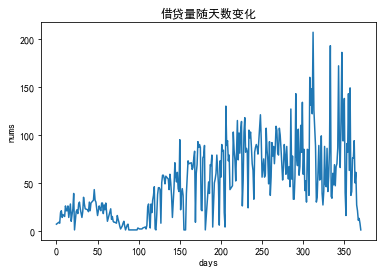

In [14]:
first = train['ListingInfo'].min()
print('start time:', first)
train['duration'] = (train['ListingInfo']-first).apply(lambda x: x.days)
test['duration'] = (test['ListingInfo']-first).apply(lambda x: x.days)
del train['ListingInfo']
del test['ListingInfo']
x = sorted(Counter(train['duration']))
y = []
for i in x:
    y.append(Counter(train['duration'])[i])
fig = plt.figure()
plt.xlabel('days')
plt.ylabel('nums')
plt.title('借贷量随天数变化')
plt.plot(x, y)
plt.show()

### 3.3 地区处理
&emsp;&emsp;数据集中提供了用户的地理位置信息，包括了七个字段：`UserInfo_2`, `UserInfo_4`, `UserInfo_6`, `UserInfo_7`, `UserInfo_18`, `UserInfo_19`, `UserInfo_23`，其中`UserInfo_7`和`UserInfo_19`是省份字段，其他是城市信息。  
&emsp;&emsp;**在这里我对城市按照城市等级进行合并**。按照城市等级，将类别变量进行合并，比如一线城市的北上广深合并，值为1，二线城市合并为二，以此类推。
## 四、数据不平衡处理
&emsp;&emsp;这里通过SMOTE对数据进行过采样处理，可以看见处理后数据从10:1的高度不平衡，变为了01占比相同的平衡数据集。

In [15]:
from imblearn.over_sampling import SMOTE
print('Original dataset shape {}'.format(Counter(train_target)))
sm = SMOTE(random_state=2018)
X_resampled, y_resampled = sm.fit_sample(train, train_target)
print('Resampled dataset shape {}'.format(Counter(y_resampled)))
X_resampled = pd.DataFrame(X_resampled, columns = train.columns)
y_resampled = pd.Series(y_resampled)

Original dataset shape Counter({0: 16544, 1: 1336})
Resampled dataset shape Counter({0: 16544, 1: 16544})


## 五、模型建立
### 5.1 single XGBoost
我首先使用了XGBoost进行建模。

In [402]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_resampled, label = y_resampled)
dval = xgb.DMatrix(test, label = test_target)
params = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 5,
         'lambda': 10,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 1,
         'eta': 0.025,
         'seed': 2018,
         'silent':1
         }
watchlist = [(dtrain, 'train'), (dval, 'val')]
%time cv_log = xgb.cv(params, dtrain, num_boost_round = 5000, nfold = 5, metrics='auc',early_stopping_rounds=50, verbose_eval=100, seed=2018)

[0]	train-auc:0.897773+0.00998955	test-auc:0.893605+0.0124182
[100]	train-auc:0.980162+0.000484291	test-auc:0.97704+0.00179055
[200]	train-auc:0.984945+0.00041063	test-auc:0.979553+0.00189295
[300]	train-auc:0.988476+0.000292448	test-auc:0.98074+0.00192168
[400]	train-auc:0.991412+0.000248662	test-auc:0.981717+0.00176314
[500]	train-auc:0.993696+0.00020214	test-auc:0.98228+0.0017305
[600]	train-auc:0.995547+0.000117479	test-auc:0.982689+0.00170706
[700]	train-auc:0.996903+0.000127008	test-auc:0.98299+0.00172087
[800]	train-auc:0.99787+7.92126e-05	test-auc:0.983184+0.00168521
[900]	train-auc:0.998591+6.86982e-05	test-auc:0.983279+0.0015821
[1000]	train-auc:0.999082+4.91813e-05	test-auc:0.983364+0.00152281
[1100]	train-auc:0.999423+2.37318e-05	test-auc:0.983461+0.00153104
[1200]	train-auc:0.999645+1.84217e-05	test-auc:0.98352+0.00149707
[1300]	train-auc:0.999782+1.49077e-05	test-auc:0.983601+0.00150369
[1400]	train-auc:0.999872+1.16516e-05	test-auc:0.983658+0.00149679
[1500]	train-auc:0.

In [406]:
print('\nbest nround when max_depth = 5: %d' %(len(cv_log)))


best nround when max_depth = 5: 1988


In [407]:
params['num_boost_round'] = len(cv_log)
%time model = xgb.train(params, dtrain, evals = watchlist)

[0]	train-auc:0.903665	val-auc:0.592543
[1]	train-auc:0.913632	val-auc:0.600112
[2]	train-auc:0.927592	val-auc:0.609488
[3]	train-auc:0.938517	val-auc:0.616247
[4]	train-auc:0.94325	val-auc:0.620929
[5]	train-auc:0.943542	val-auc:0.617593
[6]	train-auc:0.945654	val-auc:0.621294
[7]	train-auc:0.946311	val-auc:0.621942
[8]	train-auc:0.94764	val-auc:0.62928
[9]	train-auc:0.948991	val-auc:0.630574
Wall time: 6.34 s


In [419]:
test_y = model.predict(dval)
test_y = (test_y>=0.5)*1
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
print('Accuracy: %.4g' %accuracy_score(test_target, test_y))
print('f1_score: %.4g' %f1_score(test_target, test_y))
print('auc: %.4g' %roc_auc_score(test_target, test_y))
print('confusion matrix:\n', confusion_matrix(test_target, test_y))

Accuracy: 0.9157
f1_score: 0.05479
auc: 0.5093
confusion matrix:
 [[8219  123]
 [ 636   22]]


将预测值代入老师上传的盈利计算文件中，得到如下结果：

|优化前收入（亿）| 实际收入（亿）| 提升百分比（%） | 收益增加（亿） |
|:-:|:-:|:-:|:-:|
| 176200 | 185900 | 5.5051 | 33.0307 | 


### 5.2 Logistic Regression
&emsp;&emsp;由于逻辑回归的可解释性比较强，效果也还行，它被广泛地用于解决互联网领域地分类问题。因此，在这里我也尝试使用了逻辑回归进行处理。  
&emsp;&emsp;由于逻辑回归预测时无法处理缺失值，使用缺失值的前面一个值来填充该缺失值。

In [18]:
from sklearn.linear_model import LogisticRegression
import copy
LR = LogisticRegression()
%time model_lr = LR.fit(X_resampled, y_resampled)
test_rmna = copy.deepcopy(test)
test_rmna.fillna(method = 'ffill', inplace = True)
test_y_lr = model_lr.predict(test_rmna)
print('Accuracy: %.4g' %accuracy_score(test_target, test_y_lr))
print('f1_score: %.4g' %f1_score(test_target, test_y_lr))
print('auc: %.4g' %roc_auc_score(test_target, test_y_lr))
print('confusion matrix:\n', confusion_matrix(test_target, test_y_lr))

Wall time: 2min 13s
Accuracy: 0.6533
f1_score: 0.2008
auc: 0.6268
confusion matrix:
 [[5488 2854]
 [ 266  392]]


&emsp;&emsp;将预测值代入老师上传的盈利计算文件中，得到如下结果：

|优化前收入（亿）| 实际收入（亿）| 提升百分比（%） | 收益增加（亿） |
|:-:|:-:|:-:|:-:|
| 176200 | 282800 | 60.4994 | 362.9966 | 
&emsp;&emsp;可以看出从收益的角度来看，表现远远优于xgboost，并且耗时也远远短于xgboost，万万没想到。

### 5.3 多模型Stacking（Logistic/Ridge+(LR+CART+RF)）
&emsp;&emsp;可能单个模型的效果不够理想，若想得到更好的结果，就需要把单个模型的结果融合在一起，因此我也尝试了Stacking进行模型融合。  
&emsp;&emsp;这里使用两层stacking，第一层的基模型选取的是逻辑回归，单一CART决策树和随机森林。本来为了多元化采取的是逻辑回归+随机森林+XGBoost+支持向量机这一想象中效果会比较好的组合，但是SVM和XGB算法太耗时（SVM一层需要约三小时），经不起交叉验证的折腾，于是变成了LR+CART+RF这一组合。第二层使用了两种模型，一种还是逻辑回归，另一种是岭回归，从收益、f-score来看后者表现更优秀。


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import time;
init_params = {
    'LR': {
        'penalty': 'l2', 'class_weight': 'balanced'
    },
    'XGB': {
         'objective': 'binary:logistic',
         'max_depth': 5,
         'scale_pos_weight': 6,
         'n_estimators': 1500,
         'reg_lambda': 100,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 1,
         'learning_rate': 0.025,
         'seed': 2018,
         'silent':True
    },
    'RF': {
        'n_estimators': 400, 'n_jobs': -1, 'criterion': 'gini',
        'min_samples_leaf': 3, 'bootstrap': False,
        'max_depth': 12, 'min_samples_split': 6
    },
    'SVM': {
        'C': 5, 'kernel': 'rbf', 'gamma': 0.001, 'probability': True, 'cache_size': 7000,
        'class_weight': 'balanced','verbose': True,'random_state': 2018
    },
    'CART': {
        'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'random_state': 2018
    }
}

clfs = [
#     svm.SVC().set_params(**init_params.get('SVM')),
    DecisionTreeClassifier().set_params(**init_params.get('CART')),
    RandomForestClassifier().set_params(**init_params.get('RF')),
    LogisticRegression().set_params(**init_params.get('LR')),
#     xgb.XGBClassifier().set_params(**init_params.get('XGB'))
]

skf = StratifiedKFold(n_splits = 4, random_state = 2018)

train_stack = np.zeros((X_resampled.shape[0], len(clfs)))
test_stack = np.zeros((test.shape[0], len(clfs)))



for i, clf in enumerate(clfs):
    print(i, clf)
    test_stack_i = np.zeros((test.shape[0], 4))
    j = -1
    for train, test_cv in skf.split(X_resampled, y_resampled):
        time_start = time.time()
        j = j+1
        trainset_x = X_resampled.loc[train]
        trainset_y = y_resampled[train]
        test_cvset_x = X_resampled.loc[test_cv]
        test_cvset_y = y_resampled[test_cv]
        clf.fit(trainset_x, trainset_y)
        test_cvset_y_pred = clf.predict_proba(test_cvset_x)[:, 1]
        train_stack[test_cv, i] = test_cvset_y_pred
        try:
            test_stack_i[:, j] = clf.predict_proba(test)[:, 1]
        except ValueError:
            test_stack_i[:, j] = clf.predict_proba(test_rmna)[:, 1]
        time_end = time.time()
        print('Fold', j, 'running time:', time_end-time_start)
    test_stack[:, i] = test_stack_i.mean(1)    
    print('auc: %.4g' %roc_auc_score(test_target, test_stack[:, i]))

0 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2018,
            splitter='best')
Fold 0
Fold 0 running time: 5.975743055343628
Fold 1
Fold 1 running time: 6.623552322387695
Fold 2
Fold 2 running time: 6.56450891494751
Fold 3
Fold 3 running time: 6.267755508422852
auc: 0.5981
1 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 0 running time: 97.

In [17]:
clf = LogisticRegression(C = 2, class_weight = 'balanced', n_jobs = -1)
%time clf.fit(train_stack, y_resampled)
pred_stacking = clf.predict(test_stack)
print('Accuracy: %.4g' %accuracy_score(test_target, pred_stacking))
print('f1_score: %.4g' %f1_score(test_target, pred_stacking))
print('auc: %.4g' %roc_auc_score(test_target, pred_stacking))
print('confusion matrix:\n', confusion_matrix(test_target, pred_stacking))       

Wall time: 127 ms
Accuracy: 0.9221
f1_score: 0.04885
auc: 0.51
confusion matrix:
 [[8281   61]
 [ 640   18]]


&emsp;&emsp;将预测值代入老师上传的盈利计算文件中，得到如下结果：

|优化前收入（亿）| 实际收入（亿）| 提升百分比（%） | 收益增加（亿） |
|:-:|:-:|:-:|:-:|
| 176200 | 188100 | 6.7537 | 40.5221 |

In [25]:
from sklearn.linear_model import RidgeCV
# clf = LogisticRegression(C = 2, class_weight = 'balanced', n_jobs = -1)
clf = RidgeCV(alphas=np.linspace(0, 200), cv=100)
%time clf.fit(train_stack, y_resampled)
pred_stacking = clf.predict(test_stack)
pred_ridge = (pred_stacking - pred_stacking.min()) / (pred_stacking.max() - pred_stacking.min())
pred_ridge = (pred_ridge>=0.5)*1
print('Accuracy: %.4g' %accuracy_score(test_target, pred_ridge))
print('f1_score: %.4g' %f1_score(test_target, pred_ridge))
print('auc: %.4g' %roc_auc_score(test_target, pred_ridge))
print('confusion matrix:\n', confusion_matrix(test_target, pred_ridge))   

Wall time: 1min 44s
Accuracy: 0.8697
f1_score: 0.186
auc: 0.5629
confusion matrix:
 [[7693  649]
 [ 524  134]]


&emsp;&emsp;将预测值代入老师上传的盈利计算文件中，得到如下结果：

|优化前收入（亿）| 实际收入（亿）| 提升百分比（%） | 收益增加（亿） |
|:-:|:-:|:-:|:-:|
| 176200 | 245300 | 39.2168 | 235.3008 |
&emsp;&emsp;比Logistic作为第二层训练变量表现要好很多，但是仍旧没有逻辑回归本身表现好。

## 五、总结
&emsp;&emsp;将以上四个模型预测结果进行汇总：

模型类别|优化前收入（亿）| 实际收入（亿）| 提升百分比（%） | 收益增加（亿）| f_score
:-:|:-:|:-:|:-:|:-:|:-:
single XGBoost| 176200 | 185900 | 5.5051 | 33.0307 | 0.05479
Logistic Regression| 176200 | 282800 | 60.4994 | 362.9966 | 0.2008
Logistic+(LR+CART+RF)| 176200 | 188100 | 6.7537 | 40.5221 | 0.04885
Ridge+(LR+CART+RF)| 176200 | 245300 | 39.2168 | 235.3008 |  0.186
&emsp;&emsp;可以看到，表现最好的模型为Logistic Regression，提升比例达到了60%,表现最差的为XGBoost，仅提升了5%，如果没有计算错误的话，这是一次完美的农民逆袭科学家的案例！